# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

Import all require python libraries

In [5]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

Using BeautifulSoup web scrape all greater Perth suburb names from a wiki page

In [6]:
# scrape data from website
source = requests.get('https://en.wikipedia.org/wiki/List_of_Perth_suburbs').text

# create soup - parse source 
soup = BeautifulSoup(source, 'lxml')
#print(soup.prettify())

Add all suburb names into new Dataframe

In [10]:
# get table that contains list of suburbs
data_table = soup.find("table",{"class":"wikitable sortable"})

#creates a new empty dataframe
df_perth_suburbs = pd.DataFrame(columns=['Suburb', 'Latitude', 'Longitude', 'latlon'])

# find all td / cell elements in table, table has two columns so only process first column
for col in data_table.find_all('td')[::2]:
    suburb = col.a.text
    # add suburb to our dataframe
    df_perth_suburbs = df_perth_suburbs.append({'Suburb': suburb}, ignore_index=True)

# explore newly created dataframe
df_perth_suburbs.head()

,Suburb,Latitude,Longitude,latlon
0,Alexander Heights,NaN,NaN,NaN
1,Alfred Cove,NaN,NaN,NaN
2,Alkimos,NaN,NaN,NaN
3,Anketell,NaN,NaN,NaN
4,Applecross,NaN,NaN,NaN


Let's see how many suburbs we have

In [11]:
df_perth_suburbs.shape
print('The Greater Perth region has {} suburbs'.format(df_perth_suburbs.shape[0]))

The Greater Perth region has 355 suburbs


Get Perth City geospacial data using geopy

In [12]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="perth_explorer")

address = '6000, Western Australia'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

Now get the geospacial data for all suburbs using geopy

In [13]:
# keep on getting a 'GeocoderTimedOut: Service timed out' error even though the timeout setting is set to None
#from geopy.extra.rate_limiter import RateLimiter
#geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

#df_perth_suburbs['location'] = df_perth_suburbs['Suburb'].apply(geocode)
#df_perth_suburbs['point'] = df_perth_suburbs['location'].apply(lambda loc: tuple(loc.point) if loc else None)

# decided to run the cell a few times until all dataframe rows have been set
import geopy.geocoders
geopy.geocoders.options.default_timeout = None

# get all lat long data and add to our dataframe
for index, row in df_perth_suburbs.iterrows():
    # don't reprocess orws where we already have the lat lon data
    if pd.notnull(row['Latitude']): continue
        
    suburb = row['Suburb']
    print(suburb)
    location = geolocator.geocode('{}, Western Australia'.format(suburb))
    # ensure suburb was found
    if location != None:
        df_perth_suburbs.at[index,'latlon'] = (location.latitude, location.longitude)
        df_perth_suburbs.at[index,'Latitude'] = location.latitude
        df_perth_suburbs.at[index,'Longitude'] = location.longitude

Alexander Heights
Alfred Cove
Alkimos
Anketell
Applecross
Ardross
Armadale
Ascot
Ashby
Ashendon
Ashfield
Attadale
Atwell
Aubin Grove
Aveley
Bailup
Balcatta
Baldivis
Balga
Ballajura
Banjup
Banksia Grove
Baskerville
Bassendean
Bateman
Bayswater
Beaconsfield
Beckenham
Bedford
Bedfordale
Beechboro
Beechina
Beeliar
Beldon
Belhus
Bellevue
Belmont
Bentley
Bennett Springs
Bertram
Bibra Lake
Bickley
Bicton
Booragoon
Boya
Brabham
Brentwood
Brigadoon
Brookdale
Bull Creek
Bullsbrook
Burns Beach
Burswood
Butler
Byford
Calista
Camillo
Canning Mills
Canning Vale
Cannington
Carabooda
Cardup
Carine
Carlisle
Carmel
Carramar
Casuarina
Caversham
Champion Lakes
Chidlow
Churchlands
City Beach
Claremont
Clarkson
Cloverdale
Cockburn Central
Como
Connolly
Coogee
Coolbellup
Coolbinia
Cooloongup
Cottesloe
Craigie
Crawley
Cullacabardee
Currambine
Daglish
Dalkeith
Darch
Darling Downs
Darlington
Dayton
Dianella
Doubleview
Duncraig
East Cannington
East Fremantle
East Perth
East Rockingham
East Victoria Park
Eden Hil

,Suburb,Latitude,Longitude,latlon
0,Alexander Heights,-31.8272,115.866,"(-31.8271578, 115.865815)"
1,Alfred Cove,-32.0305,115.815,"(-32.03045, 115.8151)"
2,Alkimos,-31.6152,115.687,"(-31.6151987, 115.6874428)"
3,Anketell,-28.0126,118.858,"(-28.01259, 118.8578245)"
4,Applecross,-32.014,115.84,"(-32.0140001, 115.8395158)"


Let's look at the result

In [14]:
df_perth_suburbs.head()

,Suburb,Latitude,Longitude,latlon
0,Alexander Heights,-31.8272,115.866,"(-31.8271578, 115.865815)"
1,Alfred Cove,-32.0305,115.815,"(-32.03045, 115.8151)"
2,Alkimos,-31.6152,115.687,"(-31.6151987, 115.6874428)"
3,Anketell,-28.0126,118.858,"(-28.01259, 118.8578245)"
4,Applecross,-32.014,115.84,"(-32.0140001, 115.8395158)"


Remove all rows from our dataframe where the latitude and longitude data could not be retrieved

In [15]:
df_perth_suburbs.dropna(inplace=True)
df_perth_suburbs.shape

(353, 4)

Let's start to render our results on a map using folium

In [220]:
import folium # map rendering library

# create map of New York using latitude and longitude values
map_perth = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, suburb in zip(df_perth_suburbs['Latitude'], df_perth_suburbs['Longitude'], df_perth_suburbs['Suburb']):
    label = '{}'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_perth)

map_perth

Looks like there are a few suburbs outside of our general city area (outliers). Let's determine the distance between each suburb and it's closest neighbor using the geopy distance method. This distance will later help determine what our search radius will be.

In [17]:
import geopy.distance

def getDistanceToClosestNeigboringSuburb(latlon):
    closest_neighbour = 0
    
    for i, row in df_perth_suburbs.iterrows():
        # don't compare with itself
        if latlon == tuple([row['Latitude'], row['Longitude']]): continue
        
        coords_1 = latlon
        coords_2 = [row['Latitude'], row['Longitude']]
        suburb_dist = geopy.distance.distance(coords_1, coords_2).km
        
        if closest_neighbour == 0 or suburb_dist < closest_neighbour:
            closest_neighbour = suburb_dist
    return closest_neighbour
    #df_perth_suburbs.at[i,'Distance To Neighbouring Suburb'] = closest_neighbour

Calculate the distance between each suburbs' closest neighbor and add the results to our dataframe

In [18]:
df_perth_suburbs['km Distance to Closest Neighbour'] = df_perth_suburbs['latlon'].apply(getDistanceToClosestNeigboringSuburb)
df_perth_suburbs

,Suburb,Latitude,Longitude,latlon,km Distance to Closest Neighbour
0,Alexander Heights,-31.8272,115.866,"(-31.8271578, 115.865815)",1.710014
1,Alfred Cove,-32.0305,115.815,"(-32.03045, 115.8151)",1.304346
2,Alkimos,-31.6152,115.687,"(-31.6151987, 115.6874428)",3.075317
3,Anketell,-28.0126,118.858,"(-28.01259, 118.8578245)",362.611856
4,Applecross,-32.014,115.84,"(-32.0140001, 115.8395158)",1.281814
5,Ardross,-32.0255,115.838,"(-32.0255095, 115.8382524)",1.281814
6,Armadale,-32.1523,116.015,"(-32.152266, 116.0147457)",0.613049
7,Ascot,-31.9334,115.936,"(-31.9333649, 115.935544)",0.769458
8,Ashby,-31.7312,115.798,"(-31.7311903, 115.7975644)",1.476467
9,Ashendon,-32.1914,116.179,"(-32.19139, 116.1792)",10.831762


We can use a violin plot to show the distribution shape of the data

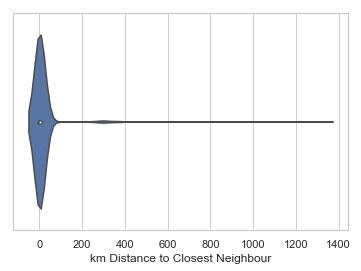

In [19]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.violinplot(x=df_perth_suburbs['km Distance to Closest Neighbour'])

From the above violin plot we can see there are a few outliers. Let's remove these outliers, meaning suburbs with a distance to it's closest neigber that is more than 50km

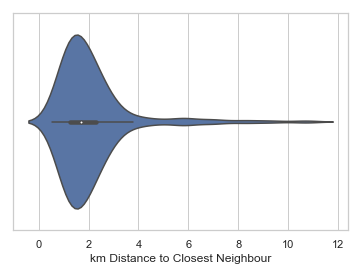

In [20]:
df_perth_suburbs = df_perth_suburbs[df_perth_suburbs['km Distance to Closest Neighbour'] < 20]
ax = sns.violinplot(x=df_perth_suburbs['km Distance to Closest Neighbour'])

That looks better. What is our mean km distance value?

In [22]:
df_perth_suburbs['km Distance to Closest Neighbour'].mean()

2.0944011515124203

Let's plot our updated results

In [23]:
import folium # map rendering library

# create map of New York using latitude and longitude values
map_perth = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, suburb in zip(df_perth_suburbs['Latitude'], df_perth_suburbs['Longitude'], df_perth_suburbs['Suburb']):
    label = '{}'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_perth)

map_perth

The FOURSQUARE API uses meters as it's unit of length, so let's convert our data from kilometers to meters and add to our dataframe. Also, for simplicity sake the distance that will be used for the search radius will be the meadian distance of the data set plus the distance to the closest neigbor. This will ensure the best generalised coverage of the suburb's surrounding area.

In [49]:
df_perth_suburbs['meter Distance to Closest Neighbour'] = df_perth_suburbs['km Distance to Closest Neighbour']
df_perth_suburbs['meter Distance to Closest Neighbour'] = df_perth_suburbs['meter Distance to Closest Neighbour'].apply(lambda dist: int(dist*1000))

mean_distance_meters = df_perth_suburbs['meter Distance to Closest Neighbour'].mean()
mean_distance_meters

C:\Users\nicol\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\nicol\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2093.930029154519

Add generalised search radius to dataframe

In [50]:
df_perth_suburbs['generalised search radius'] = df_perth_suburbs['meter Distance to Closest Neighbour'].apply(lambda dist: int(mean_distance_meters + dist))
print(df_perth_suburbs.head())

              Suburb Latitude Longitude                      latlon  \
0  Alexander Heights -31.8272   115.866   (-31.8271578, 115.865815)   
1        Alfred Cove -32.0305   115.815       (-32.03045, 115.8151)   
2            Alkimos -31.6152   115.687  (-31.6151987, 115.6874428)   
4         Applecross  -32.014    115.84  (-32.0140001, 115.8395158)   
5            Ardross -32.0255   115.838  (-32.0255095, 115.8382524)   

   km Distance to Closest Neighbour  meter Distance to Closest Neighbour  \
0                          1.710014                                 1710   
1                          1.304346                                 1304   
2                          3.075317                                 3075   
4                          1.281814                                 1281   
5                          1.281814                                 1281   

   generalised search radius  
0                       3803  
1                       3397  
2                      

C:\Users\nicol\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


We will use the FOURSQUARE API to search for venues around our suburbs. Let's get things started by setting API credentials.

In [25]:
CLIENT_ID = 'EGYTI0G4F2TLGABN035WDUOL20G0GEKZVVLVKIAIPOY1H2SM' # your Foursquare ID
CLIENT_SECRET = 'AIE3NCTP4O2M2T0HA5SRCKXQPKU4MDOD21LGN2IGZYEJCX0N' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EGYTI0G4F2TLGABN035WDUOL20G0GEKZVVLVKIAIPOY1H2SM
CLIENT_SECRET:AIE3NCTP4O2M2T0HA5SRCKXQPKU4MDOD21LGN2IGZYEJCX0N


Only specific venue categories relating to the factors mentioned in our Data section of our report will be used as features in our dataset, these include:

**Categories**
- Arts & Entertainment - 4d4b7104d754a06370d81259
- College & University - 4d4b7105d754a06372d81259
- Outdoors & Recreation - 4d4b7105d754a06377d81259
- Shop & Service
    * Child Care Service - 5744ccdfe4b0c0459246b4c7
    * Pharmacy - 4bf58dd8d48988d10f951735
    * Stationery Store - 52f2ab2ebcbc57f1066b8b21
- Professional & Other Places
    * School - 4bf58dd8d48988d13b941735
    * Medical Center - 4bf58dd8d48988d104941735

Categories list of ids

In [33]:
category_list = [
    '4d4b7104d754a06370d81259',
    '4d4b7105d754a06372d81259',
    '4d4b7105d754a06377d81259',
    '5744ccdfe4b0c0459246b4c7',
    '4bf58dd8d48988d10f951735',
    '52f2ab2ebcbc57f1066b8b21',
    '4bf58dd8d48988d13b941735',
    '4bf58dd8d48988d104941735'
]

We'll need a definition to get all venues. The definition will only use above categories by using the FOURSQUARE categoryId parameter to pass in our desired list of categories.

In [57]:
def getNearbyVenues(names, latitudes, longitudes, radius, LIMIT=100):
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        #print(name+", "+str(rad))
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            LIMIT,
            ",".join(category_list)
        )
        
        # make the GET request
        #results = requests.get(url).json()["response"]['groups'][0]['items']
        results = requests.get(url).json()["response"]
        if 'groups' in results:
            results = results['groups'][0]['items']
        else: continue
        
        #print(results)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Ok, let's get venues for all Perth suburbs

In [56]:
perth_venues = getNearbyVenues(
    names=df_perth_suburbs['Suburb'],
    latitudes=df_perth_suburbs['Latitude'],
    longitudes=df_perth_suburbs['Longitude'],
    radius=df_perth_suburbs['generalised search radius']
)

342


Analyze Each Suburb's venues

In [58]:
# one hot encoding
perth_onehot = pd.get_dummies(perth_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
perth_onehot['Suburb'] = perth_venues['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [perth_onehot.columns[-1]] + list(perth_onehot.columns[:-1])
perth_onehot = perth_onehot[fixed_columns]
perth_onehot.head()

,Suburb,Art Gallery,Arts & Entertainment,Circus,Comedy Club,Concert Hall,Dance Studio,History Museum,Indie Movie Theater,Jazz Club,...,Outdoor Sculpture,Performing Arts Venue,Public Art,Rock Club,Roller Rink,Salsa Club,Science Museum,Theater,Tour Provider,Zoo Exhibit
0,Alexander Heights,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alfred Cove,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alfred Cove,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alfred Cove,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alkimos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
perth_onehot.shape

(1956, 28)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [60]:
perth_grouped = perth_onehot.groupby('Suburb').mean().reset_index()
perth_grouped

,Suburb,Art Gallery,Arts & Entertainment,Circus,Comedy Club,Concert Hall,Dance Studio,History Museum,Indie Movie Theater,Jazz Club,...,Outdoor Sculpture,Performing Arts Venue,Public Art,Rock Club,Roller Rink,Salsa Club,Science Museum,Theater,Tour Provider,Zoo Exhibit
0,Alexander Heights,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,Alfred Cove,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,Alkimos,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,Applecross,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,Ardross,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
5,Armadale,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000
6,Ascot,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
7,Ashby,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.000000,0.000000
8,Ashendon,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.500000,0.000000,0.000000
9,Ashfield,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


Let's write functions to sort the venues in descending order and return top x results

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [186]:
def return_most_uncommon_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Build dataframe with sorted venues

In [198]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
suburb_common_venues_sorted = pd.DataFrame(columns=columns)
suburb_common_venues_sorted['Suburb'] = perth_grouped['Suburb']

for ind in np.arange(perth_grouped.shape[0]):
    suburb_common_venues_sorted.iloc[ind, 1:] = return_most_common_venues(perth_grouped.iloc[ind, :], num_top_venues)

suburb_common_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alexander Heights,Dance Studio,Zoo Exhibit,Movie Theater,Arts & Entertainment,Circus
1,Alfred Cove,Dance Studio,Movie Theater,Zoo Exhibit,Arts & Entertainment,Circus
2,Alkimos,Arts & Entertainment,Music Venue,Zoo Exhibit,Movie Theater,Circus
3,Applecross,Art Gallery,Movie Theater,Dance Studio,Indie Movie Theater,Arts & Entertainment
4,Ardross,Art Gallery,Movie Theater,Dance Studio,History Museum,Arts & Entertainment


In [199]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Uncommon Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Uncommon Venue'.format(ind+1))

# create a new dataframe
suburb_uncommon_venues_sorted = pd.DataFrame(columns=columns)
suburb_uncommon_venues_sorted['Suburb'] = perth_grouped['Suburb']

for ind in np.arange(perth_grouped.shape[0]):
    suburb_uncommon_venues_sorted.iloc[ind, 1:] = return_most_uncommon_venues(perth_grouped.iloc[ind, :], num_top_venues)

suburb_uncommon_venues_sorted.head()

,Suburb,1st Most Uncommon Venue,2nd Most Uncommon Venue,3rd Most Uncommon Venue,4th Most Uncommon Venue,5th Most Uncommon Venue
0,Alexander Heights,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
1,Alfred Cove,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
2,Alkimos,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
3,Applecross,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink
4,Ardross,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink


Merge our 5 top common venues dataframe and 5 top uncommon venues dataframe togeter

In [205]:
suburb_venues_sorted = suburb_common_venues_sorted.join(suburb_uncommon_venues_sorted.set_index('Suburb'), how='right', on='Suburb')
suburb_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Uncommon Venue,2nd Most Uncommon Venue,3rd Most Uncommon Venue,4th Most Uncommon Venue,5th Most Uncommon Venue
0,Alexander Heights,Dance Studio,Zoo Exhibit,Movie Theater,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
1,Alfred Cove,Dance Studio,Movie Theater,Zoo Exhibit,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
2,Alkimos,Arts & Entertainment,Music Venue,Zoo Exhibit,Movie Theater,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
3,Applecross,Art Gallery,Movie Theater,Dance Studio,Indie Movie Theater,Arts & Entertainment,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink
4,Ardross,Art Gallery,Movie Theater,Dance Studio,History Museum,Arts & Entertainment,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink


In [206]:
suburb_venues_sorted.shape

(313, 11)

### Cluster Neighborhoods

import k-means from clustering stage and Matplotlib and associated plotting modules

In [61]:
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

Run k-means to cluster the suburb into 7 clusters.

In [207]:
# set number of clusters
kclusters = 7

perth_grouped_clustering = perth_grouped.drop('Suburb', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(perth_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 1, 6, 6, 4, 2, 2, 1, 0])

Let's create a new dataframe that includes the cluster as well as the top 5 common and uncommon venues for each suburb.

In [208]:
# add clustering labels
suburb_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

del perth_merged
perth_merged = df_perth_suburbs

# merge perth_grouped with perth_venues to add latitude/longitude for each suburb
perth_merged = perth_merged.join(suburb_venues_sorted.set_index('Suburb'), how='right', on='Suburb')

In [209]:
perth_merged.head()

,Suburb,Latitude,Longitude,latlon,km Distance to Closest Neighbour,meter Distance to Closest Neighbour,generalised search radius,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Uncommon Venue,2nd Most Uncommon Venue,3rd Most Uncommon Venue,4th Most Uncommon Venue,5th Most Uncommon Venue
0,Alexander Heights,-31.8272,115.866,"(-31.8271578, 115.865815)",1.710014,1710,3803,3,Dance Studio,Zoo Exhibit,Movie Theater,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
1,Alfred Cove,-32.0305,115.815,"(-32.03045, 115.8151)",1.304346,1304,3397,3,Dance Studio,Movie Theater,Zoo Exhibit,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
2,Alkimos,-31.6152,115.687,"(-31.6151987, 115.6874428)",3.075317,3075,5168,1,Arts & Entertainment,Music Venue,Zoo Exhibit,Movie Theater,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
4,Applecross,-32.014,115.84,"(-32.0140001, 115.8395158)",1.281814,1281,3374,6,Art Gallery,Movie Theater,Dance Studio,Indie Movie Theater,Arts & Entertainment,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink
5,Ardross,-32.0255,115.838,"(-32.0255095, 115.8382524)",1.281814,1281,3374,6,Art Gallery,Movie Theater,Dance Studio,History Museum,Arts & Entertainment,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink


Finally, let's visualize the resulting clusters

In [210]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(perth_merged['Latitude'], perth_merged['Longitude'], perth_merged['Suburb'], perth_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Lets inspect all seven Clusters

#### Cluster 1

In [211]:
perth_merged.loc[perth_merged['Cluster Labels'] == 0, perth_merged.columns[[0] + list(range(8, perth_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Uncommon Venue,2nd Most Uncommon Venue,3rd Most Uncommon Venue,4th Most Uncommon Venue,5th Most Uncommon Venue
10,Ashfield,Music Venue,Museum,Zoo Exhibit,Mini Golf,Arts & Entertainment,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
53,Butler,Music Venue,Arts & Entertainment,Zoo Exhibit,Movie Theater,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
61,Cardup,Music Venue,Zoo Exhibit,Movie Theater,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
71,City Beach,Music Venue,Zoo Exhibit,Movie Theater,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
73,Clarkson,Music Venue,Art Gallery,Salsa Club,Mini Golf,Arts & Entertainment,Multiplex,Theater,Science Museum,Roller Rink,Rock Club
124,Hacketts Gully,Music Venue,Zoo Exhibit,Movie Theater,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
137,High Wycombe,Music Venue,Zoo Exhibit,Movie Theater,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
155,Jarrahdale,Music Venue,Zoo Exhibit,Movie Theater,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
165,Karragullen,Music Venue,Zoo Exhibit,Movie Theater,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
167,Karrakup,Music Venue,Zoo Exhibit,Movie Theater,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink


#### Cluster 2

In [212]:
perth_merged.loc[perth_merged['Cluster Labels'] == 1, perth_merged.columns[[0] + list(range(8, perth_merged.shape[1]))]]


,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Uncommon Venue,2nd Most Uncommon Venue,3rd Most Uncommon Venue,4th Most Uncommon Venue,5th Most Uncommon Venue
2,Alkimos,Arts & Entertainment,Music Venue,Zoo Exhibit,Movie Theater,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
9,Ashendon,Theater,Music Venue,Zoo Exhibit,Mini Golf,Arts & Entertainment,Art Gallery,Science Museum,Salsa Club,Roller Rink,Rock Club
22,Baskerville,Comedy Club,Music Venue,Zoo Exhibit,Movie Theater,Arts & Entertainment,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
39,Bertram,Performing Arts Venue,Music Venue,Tour Provider,Zoo Exhibit,Mini Golf,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
51,Burns Beach,Music Venue,Multiplex,Public Art,Movie Theater,Art Gallery,Zoo Exhibit,Salsa Club,Performing Arts Venue,Outdoor Sculpture,Opera House
54,Byford,Music Venue,Tour Provider,Zoo Exhibit,Mini Golf,Arts & Entertainment,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
55,Calista,Performing Arts Venue,Music Venue,Dance Studio,Zoo Exhibit,Mini Golf,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
90,Darling Downs,Music Venue,Tour Provider,Zoo Exhibit,Mini Golf,Arts & Entertainment,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
112,Girrawheen,Multiplex,Dance Studio,Performing Arts Venue,Music Venue,Movie Theater,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
132,Helena Valley,Music Venue,Theater,Dance Studio,Zoo Exhibit,Mini Golf,Art Gallery,Science Museum,Salsa Club,Roller Rink,Rock Club


#### Cluster 3

In [213]:
perth_merged.loc[perth_merged['Cluster Labels'] == 2, perth_merged.columns[[0] + list(range(8, perth_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Uncommon Venue,2nd Most Uncommon Venue,3rd Most Uncommon Venue,4th Most Uncommon Venue,5th Most Uncommon Venue
7,Ascot,Museum,Zoo Exhibit,Movie Theater,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
8,Ashby,Multiplex,Theater,Indie Movie Theater,Museum,Mini Golf,Art Gallery,Science Museum,Salsa Club,Roller Rink,Rock Club
17,Baldivis,Laser Tag,Tour Provider,Zoo Exhibit,Movie Theater,Arts & Entertainment,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
27,Beckenham,Multiplex,Dance Studio,History Museum,Mini Golf,Movie Theater,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
38,Bennett Springs,Zoo Exhibit,Opera House,Museum,Mini Golf,Arts & Entertainment,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
49,Bull Creek,Multiplex,Movie Theater,Dance Studio,History Museum,Arts & Entertainment,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
58,Canning Vale,Multiplex,Dance Studio,Laser Tag,Music Venue,Movie Theater,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
59,Cannington,Multiplex,History Museum,Mini Golf,Movie Theater,Arts & Entertainment,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
77,Connolly,Multiplex,Public Art,Indie Movie Theater,Movie Theater,Arts & Entertainment,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
83,Craigie,Multiplex,Concert Hall,Music Venue,Movie Theater,Arts & Entertainment,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink


#### Cluster 4

In [214]:
perth_merged.loc[perth_merged['Cluster Labels'] == 3, perth_merged.columns[[0] + list(range(8, perth_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Uncommon Venue,2nd Most Uncommon Venue,3rd Most Uncommon Venue,4th Most Uncommon Venue,5th Most Uncommon Venue
0,Alexander Heights,Dance Studio,Zoo Exhibit,Movie Theater,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
1,Alfred Cove,Dance Studio,Movie Theater,Zoo Exhibit,Arts & Entertainment,Circus,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
12,Atwell,Dance Studio,Art Gallery,Circus,Movie Theater,Arts & Entertainment,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink
14,Aveley,Dance Studio,Music Venue,Art Gallery,Tour Provider,Mini Golf,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink
18,Balga,Dance Studio,Multiplex,Performing Arts Venue,Music Venue,Movie Theater,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
19,Ballajura,Dance Studio,Opera House,Laser Tag,Zoo Exhibit,Movie Theater,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
24,Bateman,Dance Studio,Multiplex,Movie Theater,Theater,History Museum,Art Gallery,Science Museum,Salsa Club,Roller Rink,Rock Club
32,Beeliar,Dance Studio,Art Gallery,Circus,Outdoor Sculpture,Movie Theater,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink
33,Beldon,Dance Studio,Indie Movie Theater,Zoo Exhibit,Movie Theater,Arts & Entertainment,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
34,Belhus,Dance Studio,Music Venue,Comedy Club,Tour Provider,Zoo Exhibit,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink


#### Cluster 5

In [145]:
perth_merged.loc[perth_merged['Cluster Labels'] == 4, perth_merged.columns[[0] + list(range(8, perth_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
6,Armadale,Movie Theater,Dance Studio,Tour Provider,Zoo Exhibit,Arts & Entertainment,Circus,Comedy Club
16,Balcatta,Movie Theater,Rock Club,Zoo Exhibit,Arts & Entertainment,Circus,Comedy Club,Concert Hall
29,Bedfordale,Theater,Tour Provider,Movie Theater,Zoo Exhibit,Mini Golf,Arts & Entertainment,Circus
35,Bellevue,Theater,Movie Theater,Performing Arts Venue,Zoo Exhibit,Mini Golf,Arts & Entertainment,Circus
36,Belmont,Movie Theater,Zoo Exhibit,Arts & Entertainment,Circus,Comedy Club,Concert Hall,Dance Studio
48,Brookdale,Movie Theater,Dance Studio,Tour Provider,Zoo Exhibit,Arts & Entertainment,Circus,Comedy Club
62,Carine,Tour Provider,Multiplex,Movie Theater,Arts & Entertainment,Circus,Comedy Club,Concert Hall
63,Carlisle,Movie Theater,Dance Studio,Theater,Zoo Exhibit,Arts & Entertainment,Circus,Comedy Club
67,Caversham,Movie Theater,Theater,History Museum,Zoo Exhibit,Arts & Entertainment,Circus,Comedy Club
70,Churchlands,Movie Theater,Music Venue,Zoo Exhibit,Arts & Entertainment,Circus,Comedy Club,Concert Hall


#### Cluster 6

In [215]:
perth_merged.loc[perth_merged['Cluster Labels'] == 5, perth_merged.columns[[0] + list(range(8, perth_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Uncommon Venue,2nd Most Uncommon Venue,3rd Most Uncommon Venue,4th Most Uncommon Venue,5th Most Uncommon Venue
13,Aubin Grove,Circus,Zoo Exhibit,Movie Theater,Arts & Entertainment,Comedy Club,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
197,Mandogalup,Circus,Zoo Exhibit,Movie Theater,Arts & Entertainment,Comedy Club,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
331,Wattleup,Circus,Zoo Exhibit,Movie Theater,Arts & Entertainment,Comedy Club,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink


#### Cluster 7

In [216]:
perth_merged.loc[perth_merged['Cluster Labels'] == 6, perth_merged.columns[[0] + list(range(8, perth_merged.shape[1]))]]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,1st Most Uncommon Venue,2nd Most Uncommon Venue,3rd Most Uncommon Venue,4th Most Uncommon Venue,5th Most Uncommon Venue
4,Applecross,Art Gallery,Movie Theater,Dance Studio,Indie Movie Theater,Arts & Entertainment,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink
5,Ardross,Art Gallery,Movie Theater,Dance Studio,History Museum,Arts & Entertainment,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink
11,Attadale,Art Gallery,Dance Studio,Music Venue,Theater,Movie Theater,Multiplex,Science Museum,Salsa Club,Roller Rink,Rock Club
20,Banjup,Art Gallery,Circus,Dance Studio,Movie Theater,Arts & Entertainment,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink
23,Bassendean,Art Gallery,History Museum,Music Venue,Museum,Mini Golf,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink
25,Bayswater,Art Gallery,Movie Theater,Dance Studio,Arts & Entertainment,Circus,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink
26,Beaconsfield,Art Gallery,Movie Theater,Music Venue,History Museum,Theater,Multiplex,Science Museum,Salsa Club,Rock Club,Public Art
28,Bedford,Art Gallery,Theater,Music Venue,Movie Theater,Mini Golf,Multiplex,Science Museum,Salsa Club,Roller Rink,Rock Club
30,Beechboro,Comedy Club,Dance Studio,Public Art,Opera House,Music Venue,Art Gallery,Theater,Science Museum,Salsa Club,Roller Rink
41,Bickley,Art Gallery,Music Venue,Movie Theater,Arts & Entertainment,Circus,Multiplex,Theater,Science Museum,Salsa Club,Roller Rink


Let's look at the most common and uncommon venues within each cluster and see if any theme emerges

In [219]:
for x in range(7):
    df_most_common = perth_merged.loc[perth_merged['Cluster Labels'] == x, perth_merged.columns[[0] + list(range(8, perth_merged.shape[1]))]]
    
    breakdown = df_most_common['1st Most Common Venue'].value_counts().index[0]
    breakdown += ", "+df_most_common['2nd Most Common Venue'].value_counts().index[0]
    breakdown += ", "+df_most_common['3rd Most Common Venue'].value_counts().index[0]
    breakdown += ", "+df_most_common['4th Most Common Venue'].value_counts().index[0]
    breakdown += ", "+df_most_common['5th Most Common Venue'].value_counts().index[0]
    print('Cluster '+str(x+1)+" most common venues: "+breakdown)
    
    breakdown = df_most_common['1st Most Uncommon Venue'].value_counts().index[0]
    breakdown += ", "+df_most_common['2nd Most Uncommon Venue'].value_counts().index[0]
    breakdown += ", "+df_most_common['3rd Most Uncommon Venue'].value_counts().index[0]
    breakdown += ", "+df_most_common['4th Most Uncommon Venue'].value_counts().index[0]
    breakdown += ", "+df_most_common['5th Most Uncommon Venue'].value_counts().index[0]
    print('Cluster '+str(x+1)+" most uncommon venues: "+breakdown)


Cluster 1 most common venues: Music Venue, Zoo Exhibit, Movie Theater, Arts & Entertainment, Circus
Cluster 1 most uncommon venues: Art Gallery, Theater, Science Museum, Salsa Club, Roller Rink
Cluster 2 most common venues: Performing Arts Venue, Music Venue, Zoo Exhibit, Zoo Exhibit, Mini Golf
Cluster 2 most uncommon venues: Art Gallery, Theater, Science Museum, Salsa Club, Roller Rink
Cluster 3 most common venues: Multiplex, History Museum, Mini Golf, Movie Theater, Arts & Entertainment
Cluster 3 most uncommon venues: Art Gallery, Theater, Science Museum, Salsa Club, Roller Rink
Cluster 4 most common venues: Dance Studio, Art Gallery, Zoo Exhibit, Movie Theater, Arts & Entertainment
Cluster 4 most uncommon venues: Art Gallery, Theater, Science Museum, Salsa Club, Roller Rink
Cluster 5 most common venues: Movie Theater, Movie Theater, Dance Studio, Zoo Exhibit, Circus
Cluster 5 most uncommon venues: Art Gallery, Theater, Science Museum, Salsa Club, Roller Rink
Cluster 6 most common ve